# Andrew Garfinkel MTA Data Assesment 

# Import Libraries 


In [5]:
import requests
import time
from bs4 import BeautifulSoup
import pandas as pd

# Ingest Data 

## Ingest Station Data
Ingest the Remote-Booth-Station mapping file. This file allows us to join the relevant station information with the turnstile information. 

In [6]:
stations = pd.read_excel ('http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls')

## Ingest Current Data (New Schema)
Ingest the most current data to analyze the current number of units per station. This data set uses the 'new' schema.

In [7]:
#grabbing current data for first question 
current_data_url='http://web.mta.info/developers/data/nyct/turnstile/turnstile_210522.txt'
current_data = pd.read_csv(current_data_url, sep=",")
#creating date time field 
current_data["DATETIME"] = pd.to_datetime(current_data["DATE"].apply(str) +' '+ current_data["TIME"])
#cleaning up column name in case you want to union the new schema with old schema 
current_data.columns=[col.strip() for col in current_data.columns]

## Ingest 2013 Data (Old Schema) 
Ingest the data from 2013 to analyze historical data. We're also going to grab the last files from 2012 and the first file from 2013 so that we have a complete data set and the historical context to calculate the difference in 'odometer' readings. 
### Retrieve list of relevant URLs to ingest  
Retrieve a list of relevant URLs for the text files that we want to read into a dataframe.

In [8]:
#retrieve list of urls needed for 2013, including the last week of 2012 and the first week of 2014 
URL = 'http://web.mta.info/developers/turnstile.html'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
files = soup.find(id='contentbox').findAll('a')
thirteen_data=[]
for i in files: 
    link=i.get('href',None)
    if 'data' in str(link):
        date=int(link[-10:-4])
        if date>=121229 and date<=140104:
            thirteen_data.append(link)

### Ingest historical data from URLs
Ingest historical data from relevant URLs. 

In [9]:
thirteen_df=[]
for i in thirteen_data: 
    target_url=f'http://web.mta.info/developers/{i}'
    #give the function a little nap as to not overwhelm the MTA servers 
    time.sleep(1)
    namelist=['C/A','UNIT','SCP','DATE1','TIME1','DESC1','ENTRIES1','EXITS1','DATE2','TIME2','DESC2','ENTRIES2','EXITS2','DATE3','TIME3','DESC3','ENTRIES3','EXITS3','DATE4','TIME4','DESC4','ENTRIES4','EXITS4','DATE5','TIME5','DESC5','ENTRIES5','EXITS5','DATE6','TIME6','DESC6','ENTRIES6','EXITS6','DATE7','TIME7','DESC7','ENTRIES7','EXITS7','DATE8','TIME8','DESC8','ENTRIES8','EXITS8']
    thirteen_list = pd.read_csv(target_url, sep=",",names=namelist)
    thirteen_df.append(thirteen_list)
thirteen_data_frame = pd.concat(thirteen_df)

### Transform the historic data 
The historic data uses the old schema that creates a wide dataset. We're going to transform this into a narrow dataset that leverages common columns. 

In [10]:
#Unpivot and transforming data
thirteen_list=[]
for i in range(1,9):
    thirteen_narrow = thirteen_data_frame[['C/A','UNIT','SCP',f'DATE{i}',f'TIME{i}',f'DESC{i}',f'ENTRIES{i}',f'EXITS{i}']]
    thirteen_narrow=thirteen_narrow.rename(columns={f'DATE{i}':"DATE",f'TIME{i}':"TIME",f'DESC{i}':"DESC",f'ENTRIES{i}':"ENTRIES",f'EXITS{i}':"EXITS"})
    thirteen_list.append(thirteen_narrow)
thirteen_list = pd.concat(thirteen_list)

### Join in station data 
Join the Remote-Booth-Station mapping file data into the turnstile data.

In [11]:
#joining in station data 
merge_df=thirteen_list.merge(stations,how='inner', left_on=['C/A','UNIT'],right_on=['Booth','Remote'])
merge_df=merge_df.drop(columns=['Remote','Booth'])
merge_df=merge_df.rename(columns={'Station':'STATION','Line Name':"LINENAME",'Division':'DIVISION'})
merge_df["DATETIME"]=pd.to_datetime(merge_df["DATE"].apply(str) +' '+ merge_df["TIME"])

# Clean Data
As part of cleaning the data I filtered it to only include regular audit events. Given that the turnstiles function as 'odometer' readings, I calculated the difference between the current and previous reading to arrive at the amount of entries/exits per audit event. I also added a busyness field and relevant date dimensions. Finally, I filtered the data for 2013 as that is the primary scope of this analysis. 

In [12]:
#filter data for regular audit events 
merge_df=merge_df[(merge_df['DESC']=='REGULAR')]
merge_df=merge_df.sort_values(by=['C/A','UNIT','SCP','DATETIME'],ascending=(True,True,True,False))
#calculate entry and exit diffs 
merge_df["ENTRYDIFF"]=merge_df["ENTRIES"].diff(-1)
merge_df["EXITSDIFF"]=merge_df["EXITS"].diff(-1)
#add busyness column
merge_df["BUSYNESS"]=merge_df["ENTRYDIFF"]+merge_df["EXITSDIFF"]
merge_df['HOUR']=merge_df['DATETIME'].dt.hour
merge_df=merge_df[merge_df['DATETIME'].dt.year==2013]
#infer data types 
merge_df=merge_df.infer_objects()

## Profile the data 
Perform basic profiling to better understand the data and look for the presence of outliers. 

In [13]:
merge_df.describe()

,ENTRIES,EXITS,ENTRYDIFF,EXITSDIFF,BUSYNESS,HOUR
count,9.784954e+06,9.784954e+06,9.784954e+06,9.784954e+06,9.784954e+06,9.784954e+06
mean,5.054383e+06,2.914473e+06,8.718158e+02,6.730445e+02,1.544860e+03,1.093903e+01
std,3.363493e+07,3.318126e+07,1.026176e+06,1.025303e+06,1.639360e+06,6.898596e+00
min,-9.314769e+08,-8.789650e+08,-9.314769e+08,-9.797130e+08,-1.617266e+09,0.000000e+00
25%,3.321582e+05,1.925800e+05,1.200000e+01,9.000000e+00,3.600000e+01,5.000000e+00
50%,1.969045e+06,1.220182e+06,7.900000e+01,5.400000e+01,1.770000e+02,1.100000e+01
75%,5.053854e+06,3.644770e+06,2.470000e+02,1.730000e+02,4.660000e+02,1.600000e+01
max,9.168487e+08,9.797130e+08,9.168486e+08,9.719247e+08,1.626477e+09,2.300000e+01


## Outlier Removal 
Based on the above profile, it appears there are outliers for both entries and exits given the really large positive and negative values for the exits and entry differences. Although I could use statistics to try to identify outliers, I tend to favor simplicity and like to root my analysis in the real world phenomenon that the data actually represents. In this case, that is the number of individuals that go through a subway turnstile in a 4 hour period. Given that this can't be a negative number, I will drop all rows with a negative value. For the larger values, I am going to make the assumption that no more than 1 person can go through a turnstile per second, so the largest possible value in a 4 hour window is 14,400 (1 Person X 60 Seconds X 60 Minutes X 4 Hours). If I had more time, I would consider replacing these outlier values with the average for that station/time period, but for now I am just going to drop the data as it represents a small percentage of entries (~3%). 

In [14]:
merge_df=merge_df[(merge_df['ENTRYDIFF']>=0) & (merge_df['ENTRYDIFF'] <= 14400) & (merge_df['EXITSDIFF']>=0) & (merge_df['EXITSDIFF'] <= 14400)]

# Analysis

## Which station has the most number of units?
For this analysis, I am analyzing the most current data available for the week ending 5/22/21. The assumption here is that this question is asking for the current state of the subway system. I am defining unit as a 'Remote Unit for a station' and arriving at the answer by taking a unique count of units per station. 

In [15]:
current_data.groupby('STATION').UNIT.nunique().sort_values(ascending=False).reset_index(name='UNITS')[:5]

,STATION,UNITS
0,23 ST,6
1,86 ST,5
2,CANAL ST,5
3,GRD CNTRL-42 ST,4
4,125 ST,4


### Answer 
23 St station has the most units (6 units). 

## What is the total number of entries & exits across the subway system for February 1, 2013?
For this analysis, I am analyzing the historical data from February 1, 2013.

In [16]:
feb_1_summary=merge_df.loc[(merge_df['DATE']=='02-01-13'),['ENTRYDIFF','EXITSDIFF']].sum()
entries=feb_1_summary['ENTRYDIFF']
exits=feb_1_summary['EXITSDIFF']
print(f'There where {entries} entries and {exits} exits across the subway system on February 1, 2013')

There where 5738143.0 entries and 4435837.0 exits across the subway system on February 1, 2013


### Answer 
There were 5,738,143 entries and 4,435,837 exits across the subway system on February 1, 2013


# Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on February 1, 2013? What turnstile was the busiest on that date?

## Busiest Station

In [17]:
%matplotlib inline

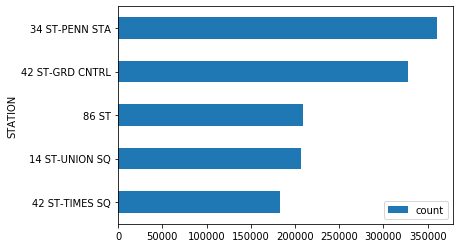

In [18]:
#busiest station
metro_feb_1=merge_df[merge_df['DATE']=='02-01-13']
metro_feb_1.groupby('STATION').BUSYNESS.sum().sort_values(ascending=False).reset_index(name='count')[:5].sort_values(by='count',ascending=True).plot.barh(x='STATION')

### Answer 
34 St-Penn Station was the busiest station on February 1, 2013 with 360,435 exits & entries 

## Busiest Turnstile 
For this analysis, a turnstile is defined as a unique combination of control area, unit, and SCP at a station. 

In [19]:
metro_feb_1.groupby(['STATION','UNIT','C/A','SCP']).BUSYNESS.sum().sort_values(ascending=False).reset_index(name='count')[:5]

,STATION,UNIT,C/A,SCP,count
0,42 ST-GRD CNTRL,R047,R240,00-00-00,13529.0
1,LEXINGTON AVE,R319,N601,00-00-00,13066.0
2,42 ST-PA BUS TE,R011,N063A,00-00-00,12188.0
3,14 ST-UNION SQ,R170,R221,01-00-00,12060.0
4,86 ST,R179,R249,01-00-09,11692.0


### Answer 
The turnstile at 42 ST-GRD CNTRL with the following attributes was the busiest turnstile on February 1,2013 with 13,529 total entries and exits. 
Unit=R047
C/A=R240 
SCP=00-00-00

# What stations have seen the most usage growth/decline in 2013?
For this analysis, I considered incorporating 2012 data to calculate YoY growth/decline metrics. I chose not to go with this approach for the sake of simplicity and to cut down on data volumes. I would consider this approach if I had more time or wanted to dig deeper. Instead, I decided to take an average of the monthly percent change in daily busyness for each station. I also compared the average daily busyness in the first half of the year to the second half of the year. 

## Average Monthly Percent Change in Average Daily Busyness 
In this approach, I calculated the average daily busyness for each month. From there, I calculated the MoM percent change in this average daily busyness. Finally, I took an average of this number for each station. One thing to be cautious of here is that the final metric is a few levels abstracted from the root data given that it is an average of a percent change of an average. For this reason, I also explored another approach.

In [20]:
usage_change=merge_df
usage_change['MONTH']=usage_change['DATETIME'].dt.month
usage_change=usage_change.groupby(['MONTH','DATE','STATION']).BUSYNESS.sum().reset_index(name='BUSYNESS')
usage_change=usage_change.groupby(['MONTH','STATION']).BUSYNESS.mean().reset_index(name='AVGBUSYNESS')
usage_change=usage_change.sort_values(by=['STATION','MONTH'],ascending=(True,True))
usage_change['PCTCHANGE']=usage_change.groupby('STATION')['AVGBUSYNESS'].pct_change()
usage_change_agg=usage_change.groupby('STATION')['PCTCHANGE'].mean().reset_index(name='AVGPCTCHANGE')

In [21]:
#Usage Decline  
usage_change_agg.sort_values(by='AVGPCTCHANGE',ascending=True)[:5]

,STATION,AVGPCTCHANGE
374,WHITEHALL ST,-0.047617
294,MURRAY ST-B'WAY,-0.039709
263,JOURNAL SQUARE,-0.032968
337,ROCKAWAY BLVD,-0.017593
189,CORTLANDT ST,-0.015085


In [22]:
#Usage Growth 
usage_change_agg.sort_values(by='AVGPCTCHANGE',ascending=False)[:5]

,STATION,AVGPCTCHANGE
145,BEACH 90 ST,22.408048
121,AQUEDUCT TRACK,20.153868
314,ORCHARD BEACH,3.802568
142,BEACH 44 ST,0.912881
146,BEACH 98 ST,0.907683


Based on this first method, Whitehall St, Murry St-B'way, and Journal Square stations had the biggest decline in 2013. Beach 90 St, Aqueduct Track, and Orchard Beach had the largest increases. The sheer magnitude of AVGPCTCHANGE for BEACH 90 ST and AQUEDUCT TRACK are worth drilling into. 

In [23]:
usage_change_outliers=usage_change[(usage_change['STATION']=='BEACH 90 ST')|(usage_change['STATION']=='AQUEDUCT TRACK')]
print(usage_change_outliers)

      MONTH         STATION  AVGBUSYNESS   PCTCHANGE
870       3  AQUEDUCT TRACK    14.500000         NaN
1246      4  AQUEDUCT TRACK     1.033333   -0.928736
1622      5  AQUEDUCT TRACK    13.875000   12.427419
2003      6  AQUEDUCT TRACK     5.333333   -0.615616
2384      7  AQUEDUCT TRACK     8.645161    0.620968
2765      8  AQUEDUCT TRACK  1475.580645  169.682836
3147      9  AQUEDUCT TRACK  1570.892857    0.064593
3529     10  AQUEDUCT TRACK  1528.741935   -0.026832
3910     11  AQUEDUCT TRACK  1984.933333    0.298410
4289     12  AQUEDUCT TRACK  1710.548387   -0.138234
143       1     BEACH 90 ST     0.903226         NaN
517       2     BEACH 90 ST     0.500000   -0.446429
893       3     BEACH 90 ST     1.741935    2.483871
1269      4     BEACH 90 ST     0.566667   -0.674691
1646      5     BEACH 90 ST   131.580645  231.201139
2027      6     BEACH 90 ST  1826.666667   12.882488
2408      7     BEACH 90 ST  2362.774194    0.293490
2789      8     BEACH 90 ST  1926.612903   -0.

Based on the above, it is clear that this method is susceptible to outliers and can also overstate growth/decline in small numbers given that it is measuring a relative not absolute change. In the case here, the increase in two months alone is severely skewing the overall metric. That being said, there appears to be seasonality in the data which makes sense given the stations provide transport to a beach and horse racetrack. 

## Percent Change in Average Daily Business for First and Second Half of the Year
In this approach, I take the average daily busyness for each station for the first and second half of the year. From there, I calculate the percent difference between the first and second half of the year. Given that this is focusing on half year periods (as opposed to monthly periods) it should be less susceptible to monthly variations in the data.

In [24]:
usage_change_half=merge_df
usage_change_half['QUARTER']=usage_change_half['DATETIME'].dt.quarter
usage_change_half['HALF']=(usage_change_half['QUARTER']>2)*1+1
usage_change_half=usage_change_half.groupby(['HALF','MONTH','DATE','STATION']).BUSYNESS.sum().reset_index(name='BUSYNESS')
usage_change_half=usage_change_half.groupby(['HALF','STATION']).BUSYNESS.mean().reset_index(name='AVGBUSYNESS')
usage_change_half=usage_change_half.sort_values(by='STATION')
usage_change_half[:15]
usage_change_half['PCTCHANGE']=usage_change_half.groupby('STATION')['AVGBUSYNESS'].pct_change()

In [25]:
#Growth 
usage_change_half_pct_change=usage_change_half[usage_change_half["HALF"]==2]
usage_change_half_pct_change.sort_values(by='PCTCHANGE',ascending=False)[:5]

,HALF,STATION,AVGBUSYNESS,PCTCHANGE
503,2,AQUEDUCT TRACK,1373.417582,208.793805
527,2,BEACH 90 ST,1752.228261,4.376209
524,2,BEACH 44 ST,976.711957,4.013325
523,2,BEACH 36 ST,1423.510870,3.331946
526,2,BEACH 67 ST,3575.489130,3.088298


In [26]:
usage_change_aque=usage_change[(usage_change['STATION']=='AQUEDUCT TRACK')]
print(usage_change_aque)

      MONTH         STATION  AVGBUSYNESS   PCTCHANGE
870       3  AQUEDUCT TRACK    14.500000         NaN
1246      4  AQUEDUCT TRACK     1.033333   -0.928736
1622      5  AQUEDUCT TRACK    13.875000   12.427419
2003      6  AQUEDUCT TRACK     5.333333   -0.615616
2384      7  AQUEDUCT TRACK     8.645161    0.620968
2765      8  AQUEDUCT TRACK  1475.580645  169.682836
3147      9  AQUEDUCT TRACK  1570.892857    0.064593
3529     10  AQUEDUCT TRACK  1528.741935   -0.026832
3910     11  AQUEDUCT TRACK  1984.933333    0.298410
4289     12  AQUEDUCT TRACK  1710.548387   -0.138234


Using this approach, the percent change growth numbers look more realistic (excluding Aqueduct Tract). For the Aqueduct Tract station, there is a large increase in average busyness in the second half of the year compared to the first half. 

In [27]:
#Decline 
usage_change_half_pct_change.sort_values(by='PCTCHANGE',ascending=True)[:5]

,HALF,STATION,AVGBUSYNESS,PCTCHANGE
628,2,HOWARD BCH-JFK,2549.315217,-0.657765
676,2,MURRAY ST-B'WAY,5101.010870,-0.383116
560,2,CENTRAL AVE,4216.802817,-0.198759
719,2,ROCKAWAY BLVD,9799.369565,-0.198084
645,2,JOURNAL SQUARE,29537.351648,-0.195963


## Usage Growth/Decline Answer 
### Growth 
Based on my analysis, Aqueduct Track and Beach 90/44 stations had the most relative growth in a single year. This is likely due to the seasonality in the data given that more people go to the beach or horse races later in the year as opposed to earlier. If compared to prior years, my guess is that the YoY growth would be far less significant than what we see in a single year. Given the framing of the question and my decision to focus on growth within a single year, I am comfortable suggesting these had the highest growth throughout the year driven by seasonality. 
### Decline 
Based on my analysis, HOWARD BCH-JFK, MURRAY ST-B'WAY, and CENTRAL AVE had the most usage decline in a year.

# What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely?
For this question, I made the assumption that we are looking within 2013. 

## Least Busy

In [28]:
merge_df.groupby(['DATE']).BUSYNESS.sum().sort_values(ascending=True).reset_index(name='count')[:5]

,DATE,count
0,12-25-13,3383886.0
1,11-28-13,4209670.0
2,02-09-13,4248448.0
3,02-03-13,4386688.0
4,01-06-13,4479505.0


### Least Busy Answer 
The least busy days of the year were 12/25/2013, 11/28/2013, and 2/9/2013. This makes sense as two of these days were holidays (Christmas/Thanksgiving) and one was during a winter storm (Winter Storm Nemo) which likely drove low subway usage. 

## Closed Entirely 
For this analysis, I defined a day with no exits/entries as a station being closed. 

In [29]:
days_closed=merge_df.groupby(['DATE','STATION']).BUSYNESS.sum().sort_values(ascending=True).reset_index(name='Busyness')
days_closed[:5]

,DATE,STATION,Busyness
0,05-18-13,BEACH 90 ST,0.0
1,02-13-13,BEACH 90 ST,0.0
2,02-26-13,BEACH 90 ST,0.0
3,06-15-13,AQUEDUCT TRACK,0.0
4,08-15-13,ORCHARD BEACH,0.0


In [30]:
days_closed.groupby(['STATION']).DATE.nunique().sort_values(ascending=False)

STATION
COURT SQ-23 ST     365
BAY RIDGE-95 ST    365
AVE J              365
AVE M              365
AVE N              365
                  ... 
BEACH 105 ST       232
ROCKAWAY PK 116    228
CENTRAL AVE        210
ORCHARD BEACH      112
LGA AIRPORT CTB      2
Name: DATE, Length: 383, dtype: int64

### Closed Entirely Answer 
I included a dataframe that includes a list of all of the dates that stations were closed entirely. I also included a dataframe that summarizes the number of days closed per station.

## Not at full capacity 
There are multiple ways to define a station operating at full capacity. One way of defining this is that all of the turnstiles are open. Another way to define this is that all trains are running in the station. I explored both. 
### Turnstiles Capacity 
For this analysis, I calculated the total number of turnstiles for each day/station and the total number of active turnstiles for each day/station. I defined an active turnstile as a turnstile that had at least 1 entry/exit in a day. From here, I calculated a ratio by dividing the number of active turnstiles by the total number of turnstiles. This ratio represents the percent of all turnstiles that are active. 

In [31]:
#Create aggregated daily dataframe
turnstile_count=merge_df.groupby(['DATE','STATION','C/A', 'UNIT','SCP']).BUSYNESS.sum().reset_index(name='BUSYNESS')

#Add a field that concatenates turnstile values 
turnstile_count['TURNSTILE']=turnstile_count['C/A']+turnstile_count['UNIT']+turnstile_count['SCP']

#Total turnstiles
total_turnstile_per_station=turnstile_count.groupby(['STATION','DATE']).TURNSTILE.nunique().reset_index(name='TOTALTURNSTILE').sort_values(by=['TOTALTURNSTILE'],ascending=False)

#Active turnstiles
active_turnstile_per_station=turnstile_count[turnstile_count['BUSYNESS']>0]
active_turnstile_per_station=active_turnstile_per_station.groupby(['STATION','DATE']).TURNSTILE.nunique().reset_index(name='ACTIVETURNSTILE').sort_values(by=['ACTIVETURNSTILE'],ascending=False)

#Merge total and active 
turnstiles=pd.merge(active_turnstile_per_station, total_turnstile_per_station, on=["STATION","DATE"])
turnstiles['RATIO']=turnstiles['ACTIVETURNSTILE']/turnstiles['TOTALTURNSTILE']
turnstiles.sort_values(by=['RATIO'],ascending=True)
turnstiles_not_full_capacity=turnstiles[turnstiles['RATIO']<.5]
turnstiles_not_full_capacity=turnstiles_not_full_capacity.sort_values(by='RATIO',ascending=True)
turnstiles_not_full_capacity[:10]

,STATION,DATE,ACTIVETURNSTILE,TOTALTURNSTILE,RATIO
137149,CORTLANDT ST,12-15-13,1,17,0.058824
137144,175 ST,04-07-13,1,16,0.062500
137499,BROAD ST,03-10-13,1,13,0.076923
136902,PATH WTC,11-17-13,2,26,0.076923
137502,BROAD ST,06-23-13,1,13,0.076923
137501,BROAD ST,04-14-13,1,13,0.076923
137488,WORLD TRADE CTR,08-25-13,1,11,0.090909
137493,231 ST,07-14-13,1,10,0.100000
137455,MOSHOLU PARKWAY,11-17-13,1,9,0.111111
137454,MOSHOLU PARKWAY,11-03-13,1,9,0.111111


The above dataframe contains all dates/stations where the ratio of active turnstiles/total turnstiles is less than 50%, suggesting the station may not be fully utilized. 

### Busyness Capacity 
For this analysis, I compared the daily busyness of a station to the median daily busyness of a station. Computing a ratio of daily busyness to the median daily busyness can help us find days where subway usage is far below the median. This could indicate that not all trains are going into a station and that a station is not being fully utilized. 

In [32]:
busy_per_day=merge_df.groupby(['DATE','STATION']).BUSYNESS.sum().reset_index(name='BUSYNESS')
busy_per_day=busy_per_day[busy_per_day['BUSYNESS']>0]
median_per_day=busy_per_day.groupby(['STATION']).BUSYNESS.median().reset_index(name='DAILYMEDIAN')
capacity = pd.merge(busy_per_day, median_per_day, on=["STATION"])
capacity['PCTMEDIAN']=capacity['BUSYNESS']/capacity['DAILYMEDIAN']
capacity=capacity[capacity['BUSYNESS']>0]
capacity=capacity[capacity['PCTMEDIAN']<.5]
capacity.sort_values(by=['PCTMEDIAN'],ascending=True)[:25]

,DATE,STATION,BUSYNESS,DAILYMEDIAN,PCTMEDIAN
112515,11-17-13,PATH WTC,2.0,88281.0,0.000023
112522,11-24-13,PATH WTC,3.0,88281.0,0.000034
52001,11-17-13,BEDFORD AVE,2.0,45220.0,0.000044
12857,04-07-13,175 ST,1.0,20276.0,0.000049
15871,07-14-13,191 ST,1.0,15701.0,0.000064
76099,08-31-13,EUCLID AVE,1.0,13100.5,0.000076
103047,11-17-13,MOSHOLU PARKWAY,1.0,12443.0,0.000080
112508,11-10-13,PATH WTC,8.0,88281.0,0.000091
20326,10-06-13,231 ST,1.0,9971.0,0.000100
21335,07-14-13,242 ST,1.0,9705.0,0.000103


The above dataframe contains all dates/stations where the daily busyness is less than 50% of the daily median busyness for that station. This list could be used to help identify days where a station is not fully utilized. 

# Bonus:  What hour is the busiest for station CANAL ST in Q1 2013?
For this analysis, I took the average and median busyness for each hour audit event at the Canal Street station in Q1 2013. The data is captured in regular audit events that represent 4 hour increments. 

In [33]:
#filter for CANAL and Q1
canal_st=merge_df[(merge_df['STATION']=='CANAL ST') & merge_df['DATETIME'].dt.quarter==1]

In [34]:
#Average per hour 
canal_st.groupby(['HOUR']).BUSYNESS.mean().reset_index(name='AVGBUSYNESS').sort_values(by=['AVGBUSYNESS'],ascending=False)[:5]

,HOUR,AVGBUSYNESS
19,21,678.014401
16,17,652.872666
18,20,646.201229
17,19,587.469723
12,13,505.758490


In [35]:
#Median per hour to understand impact of outliers 
canal_st.groupby(['HOUR']).BUSYNESS.median().reset_index(name='MEDIANBUSYNESS').sort_values(by=['MEDIANBUSYNESS'],ascending=False)[:5]

,HOUR,MEDIANBUSYNESS
19,21,657.0
16,17,643.0
18,20,580.0
12,13,471.0
15,16,441.0


### Canal Street Answer
The busiest hour at Canal Street is from the reading at 21. Assuming this is a 4 hour window, this would represent 5PM-9PM. 